<a href="https://colab.research.google.com/github/Rahmat-ML/PyTorch-Linear-DNN-Fundamentals/blob/main/notebooks/01_pytorch_workflow_fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01. PyTorch Workflow Fundamentals

This notebook implements a complete, step-by-step deep learning workflow using PyTorch. We will build a simple linear model to learn the pattern of a straight line (`y = weight * X + bias`).

## 0. Imports and Setup

First, we import the necessary libraries and set up our device-agnostic code to use a GPU if one is available.

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from pathlib import Path

# Ensure plots appear inline in the notebook
%matplotlib inline

# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


## 1. Data: Create and Prepare Linear Data

We create our data using known parameters (`WEIGHT` and `BIAS`). Then, we split it into training (80%) and testing (20%) sets. Finally, we move our data tensors to the target `device`.

In [10]:
# Create known parameters for our line equation (y = weight * X + bias)
WEIGHT = 0.7
BIAS = 0.3

# Create input data (X) and corresponding labels (y)
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1) # dim=1 ensures correct shape for linear model
y = WEIGHT * X + BIAS

# Split data into training (80%) and testing (20%) sets
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

# Send data to target device (GPU/CPU)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

print(f"Training data points: {len(X_train)}")
print(f"Testing data points: {len(X_test)}")

Training data points: 40
Testing data points: 10


Let's define a function to visualize our data.

In [11]:
def plot_predictions(train_data, train_labels, test_data, test_labels, predictions=None):
    """Plots training data, test data and compares predictions."""
    # Move data to CPU for use with Matplotlib
    train_data_cpu = train_data.cpu().numpy()
    train_labels_cpu = train_labels.cpu().numpy()
    test_data_cpu = test_data.cpu().numpy()
    test_labels_cpu = test_labels.cpu().numpy()

    plt.figure(figsize=(10, 7))
    plt.title("PyTorch Linear Regression Learning")
    plt.xlabel("X Feature")
    plt.ylabel("Y Label")

    # Plot training data in blue
    plt.scatter(train_data_cpu, train_labels_cpu, c="b", s=4, label="Training Data")

    # Plot test data in green
    plt.scatter(test_data_cpu, test_labels_cpu, c="g", s=4, label="Testing Data (True)")

    if predictions is not None:
        # Plot the predictions in red
        predictions_cpu = predictions.cpu().numpy()
        plt.scatter(test_data_cpu, predictions_cpu, c="r", s=8, marker='x', label="Predictions (Model Output)")

    plt.legend(prop={"size": 14})
    plt.grid(True)
    plt.show()

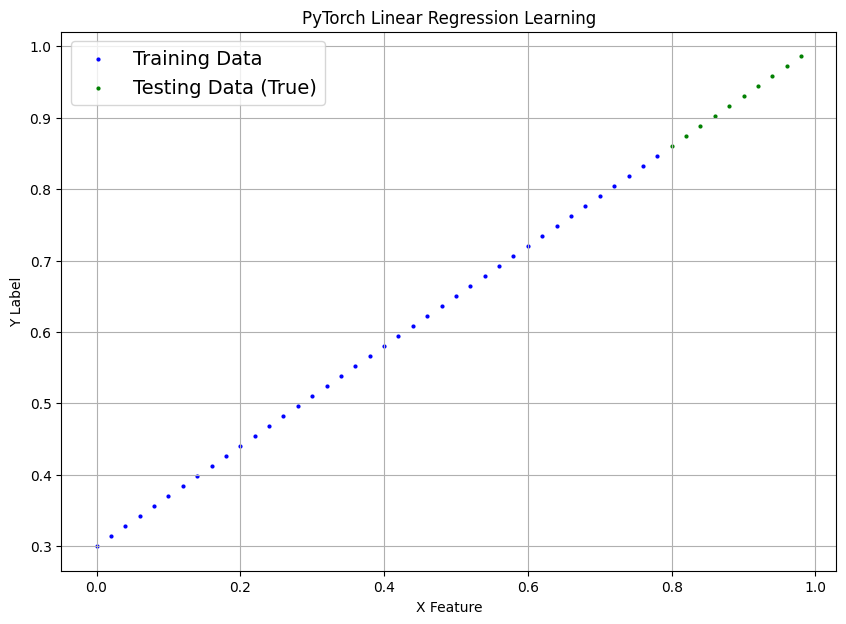

In [12]:
plot_predictions(X_train, y_train, X_test, y_test)

## 2. Build Model: The Neural Network Architecture

We subclass `nn.Module` to create our custom model. Inside, we use `nn.Linear` which automatically creates the `weight` and `bias` parameters for us.

In [21]:
# Subclass nn.Module
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # nn.Linear creates the model's parameters (weights and biases)
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    # The forward method defines the computation
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Create an instance of the model and move it to the target device
torch.manual_seed(42) # Set seed for reproducibility
model = LinearRegressionModelV2().to(device)

print("--- Initial Model Parameters (Random) ---")
print(model.state_dict())

--- Initial Model Parameters (Random) ---
OrderedDict({'linear_layer.weight': tensor([[0.7645]]), 'linear_layer.bias': tensor([0.8300])})


## 3. Loss Function and Optimizer

-   **Loss Function (`nn.L1Loss`):** Measures how wrong the model's predictions are (Mean Absolute Error).
-   **Optimizer (`torch.optim.SGD`):** Tells the model how to update its parameters to reduce the loss (Stochastic Gradient Descent).

In [22]:
# The loss function measures how wrong the model's predictions are.
loss_fn = nn.L1Loss()

# The optimizer tells the model how to update its parameters to reduce the loss.
optimizer = torch.optim.SGD(
    params=model.parameters(), # Parameters to optimize
    lr=0.01                    # Learning Rate
)

## 4. Training Loop: The Learning Process

This is the core of deep learning. We loop over the data many times (`epochs`) and perform the key steps:
1.  **Forward pass:** Get predictions.
2.  **Calculate loss:** See how wrong the predictions are.
3.  **Zero gradients:** Reset optimizer gradients.
4.  **Backpropagation:** Calculate gradients (error signals).
5.  **Optimizer step:** Update model parameters to improve.

In [23]:
epochs = 1000
print(f"--- Training for {epochs} Epochs ---")

for epoch in range(epochs):

    # 1. Set model to training mode
    model.train()

    # 2. Forward pass
    y_pred = model(X_train)

    # 3. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 4. Zero gradients
    optimizer.zero_grad()

    # 5. Backpropagation
    loss.backward()

    # 6. Optimizer step (Gradient Descent)
    optimizer.step()

    # --- Testing/Evaluation ---
    model.eval()
    with torch.inference_mode():
        test_pred = model(X_test)
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch:4d} | Train Loss: {loss:.4f} | Test Loss: {test_loss:.4f}")

--- Training for 1000 Epochs ---
Epoch:    0 | Train Loss: 0.5552 | Test Loss: 0.5740
Epoch:  100 | Train Loss: 0.0062 | Test Loss: 0.0141
Epoch:  200 | Train Loss: 0.0013 | Test Loss: 0.0138
Epoch:  300 | Train Loss: 0.0013 | Test Loss: 0.0138
Epoch:  400 | Train Loss: 0.0013 | Test Loss: 0.0138
Epoch:  500 | Train Loss: 0.0013 | Test Loss: 0.0138
Epoch:  600 | Train Loss: 0.0013 | Test Loss: 0.0138
Epoch:  700 | Train Loss: 0.0013 | Test Loss: 0.0138
Epoch:  800 | Train Loss: 0.0013 | Test Loss: 0.0138
Epoch:  900 | Train Loss: 0.0013 | Test Loss: 0.0138


After training, let's check the parameters our model has learned. They should be very close to our original `WEIGHT = 0.7` and `BIAS = 0.3`.

In [24]:
print("\n--- Final Model Parameters (Learned) ---")
print(model.state_dict())
print(f"Original Parameters: Weight={WEIGHT}, Bias={BIAS}")


--- Final Model Parameters (Learned) ---
OrderedDict({'linear_layer.weight': tensor([[0.6968]]), 'linear_layer.bias': tensor([0.3025])})
Original Parameters: Weight=0.7, Bias=0.3


## 5. Making Predictions (Inference) and Visualization

Now we use our trained model to make predictions on the test data and visualize the results. The red 'x' marks should align closely with the green 'Testing Data' points.

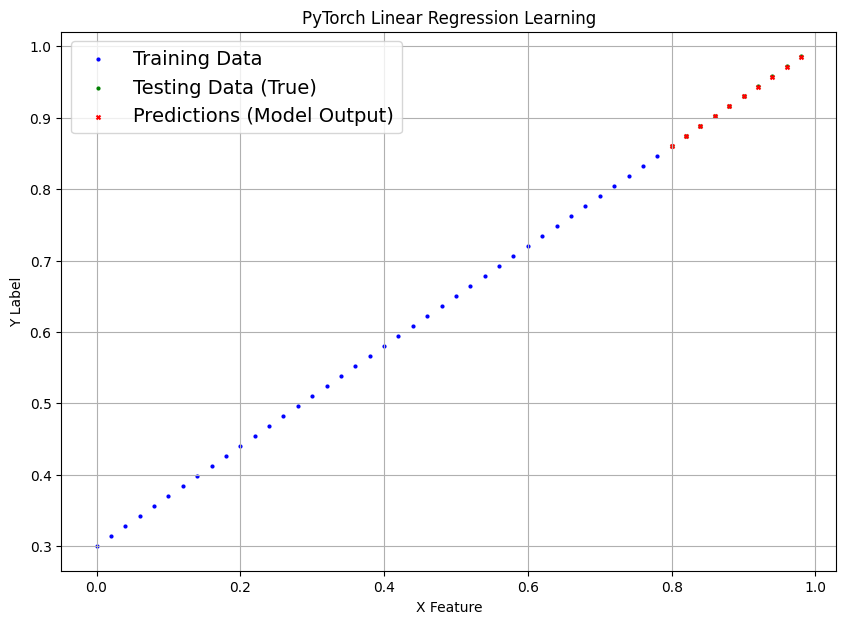

In [25]:
# Set model to evaluation mode
model.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model(X_test)

# Plot the predictions
plot_predictions(X_train, y_train, X_test, y_test, predictions=y_preds)

## 6. Saving and Loading the Model

This is crucial for deploying your model. We save the model's *parameters* (the `state_dict`) and then load them into a new, untrained instance of the model to prove it works.

In [26]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True) # Create models directory

MODEL_NAME = "linear_regression_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model's state_dict (recommended method)
print(f"Saving model state_dict to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Saving model state_dict to: models/linear_regression_model.pth


In [27]:
# Load the model state_dict

# 1. Create a new, untrained instance of the model
loaded_model = LinearRegressionModelV2().to(device)
print(f"Loaded model's initial state:\n{loaded_model.state_dict()}\n")

# 2. Load the saved parameters
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
print(f"Loaded model's *trained* state:\n{loaded_model.state_dict()}\n")

# 3. Verify predictions from the loaded model match the original model
loaded_model.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model(X_test)

is_close = torch.allclose(y_preds, loaded_model_preds)
print(f"Predictions from saved/loaded model match original predictions: {is_close}")

Loaded model's initial state:
OrderedDict({'linear_layer.weight': tensor([[-0.2343]]), 'linear_layer.bias': tensor([0.9186])})

Loaded model's *trained* state:
OrderedDict({'linear_layer.weight': tensor([[0.6968]]), 'linear_layer.bias': tensor([0.3025])})

Predictions from saved/loaded model match original predictions: True
